#Customer Churn Prediction in Telecom

**Members: April Yang, Wenjun(Charon) Song, Vatsal Nanawati**

# Import Data

In [ ]:
## Import Kaggle API
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aprilxxxyang","key":"eb1e8d31c3616ea0b95c4066e7ad6612"}'}

In [5]:
# Import packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from collections import Counter
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score,recall_score,precision_score
from sklearn.metrics import f1_score,roc_auc_score, roc_curve, auc

In [6]:
# Move kaggle.json to the correct directory
os.makedirs('/root/.kaggle', exist_ok=True)
!mv kaggle.json /root/.kaggle/

# Set permissions
!chmod 600 /root/.kaggle/kaggle.json

# Download the dataset
!kaggle datasets download -d mnassrib/telecom-churn-datasets

# Unzip the dataset
!unzip telecom-churn-datasets.zip

mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/mnassrib/telecom-churn-datasets
License(s): copyright-authors
  0% 0.00/99.5k [00:00<?, ?B/s]
100% 99.5k/99.5k [00:00<00:00, 40.9MB/s]
Archive:  telecom-churn-datasets.zip
  inflating: churn-bigml-20.csv      
  inflating: churn-bigml-80.csv      


In [7]:
# Load datasets
train = pd.read_csv('churn-bigml-80.csv')
test = pd.read_csv('churn-bigml-20.csv')

# Combine both datasets into one
churn_combined = pd.concat([train, test], ignore_index=True)

# Display the first few rows of the combined dataset
print(churn_combined.head())


  State  Account length  Area code International plan Voice mail plan  \
0    KS             128        415                 No             Yes   
1    OH             107        415                 No             Yes   
2    NJ             137        415                 No              No   
3    OH              84        408                Yes              No   
4    OK              75        415                Yes              No   

   Number vmail messages  Total day minutes  Total day calls  \
0                     25              265.1              110   
1                     26              161.6              123   
2                      0              243.4              114   
3                      0              299.4               71   
4                      0              166.7              113   

   Total day charge  Total eve minutes  Total eve calls  Total eve charge  \
0             45.07              197.4               99             16.78   
1             27.47   

# EDA

In [8]:
# Identify missing values
missing_values = churn_combined.isnull().sum()
print(missing_values)

State                     0
Account length            0
Area code                 0
International plan        0
Voice mail plan           0
Number vmail messages     0
Total day minutes         0
Total day calls           0
Total day charge          0
Total eve minutes         0
Total eve calls           0
Total eve charge          0
Total night minutes       0
Total night calls         0
Total night charge        0
Total intl minutes        0
Total intl calls          0
Total intl charge         0
Customer service calls    0
Churn                     0
dtype: int64


There is no missing value in the dataset

In [9]:
# Identify duplicates
churn_combined.duplicated().sum()

0

There is no duplicates in the dataset

In [10]:

# Convert categorical columns to numerical (0/1)
cat_cols = ['International plan', 'Voice mail plan']
churn_combined[cat_cols] = churn_combined[cat_cols].replace({'Yes': 1, 'No': 0})

churn_combined['Churn'] = churn_combined['Churn'].astype(int)

# get numerical columns (excluding 'Churn')
numerical_columns = churn_combined.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_columns = [col for col in numerical_columns if col != 'Churn']

# Display first few rows to verify encoding
print(churn_combined[['International plan', 'Voice mail plan', 'Churn']].head())

charge_cols = ['Total day charge', 'Total eve charge', 'Total night charge', 'Total intl charge']
churn_combined['Monthly Charge'] = churn_combined[charge_cols].sum(axis=1)



   International plan  Voice mail plan  Churn
0                   0                1      0
1                   0                1      0
2                   0                0      0
3                   1                0      0
4                   1                0      0


<ipython-input-10-c8bb0a998337>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  churn_combined[cat_cols] = churn_combined[cat_cols].replace({'Yes': 1, 'No': 0})


In [11]:
print(churn_combined.head())

  State  Account length  Area code  International plan  Voice mail plan  \
0    KS             128        415                   0                1   
1    OH             107        415                   0                1   
2    NJ             137        415                   0                0   
3    OH              84        408                   1                0   
4    OK              75        415                   1                0   

   Number vmail messages  Total day minutes  Total day calls  \
0                     25              265.1              110   
1                     26              161.6              123   
2                      0              243.4              114   
3                      0              299.4               71   
4                      0              166.7              113   

   Total day charge  Total eve minutes  ...  Total eve charge  \
0             45.07              197.4  ...             16.78   
1             27.47              1

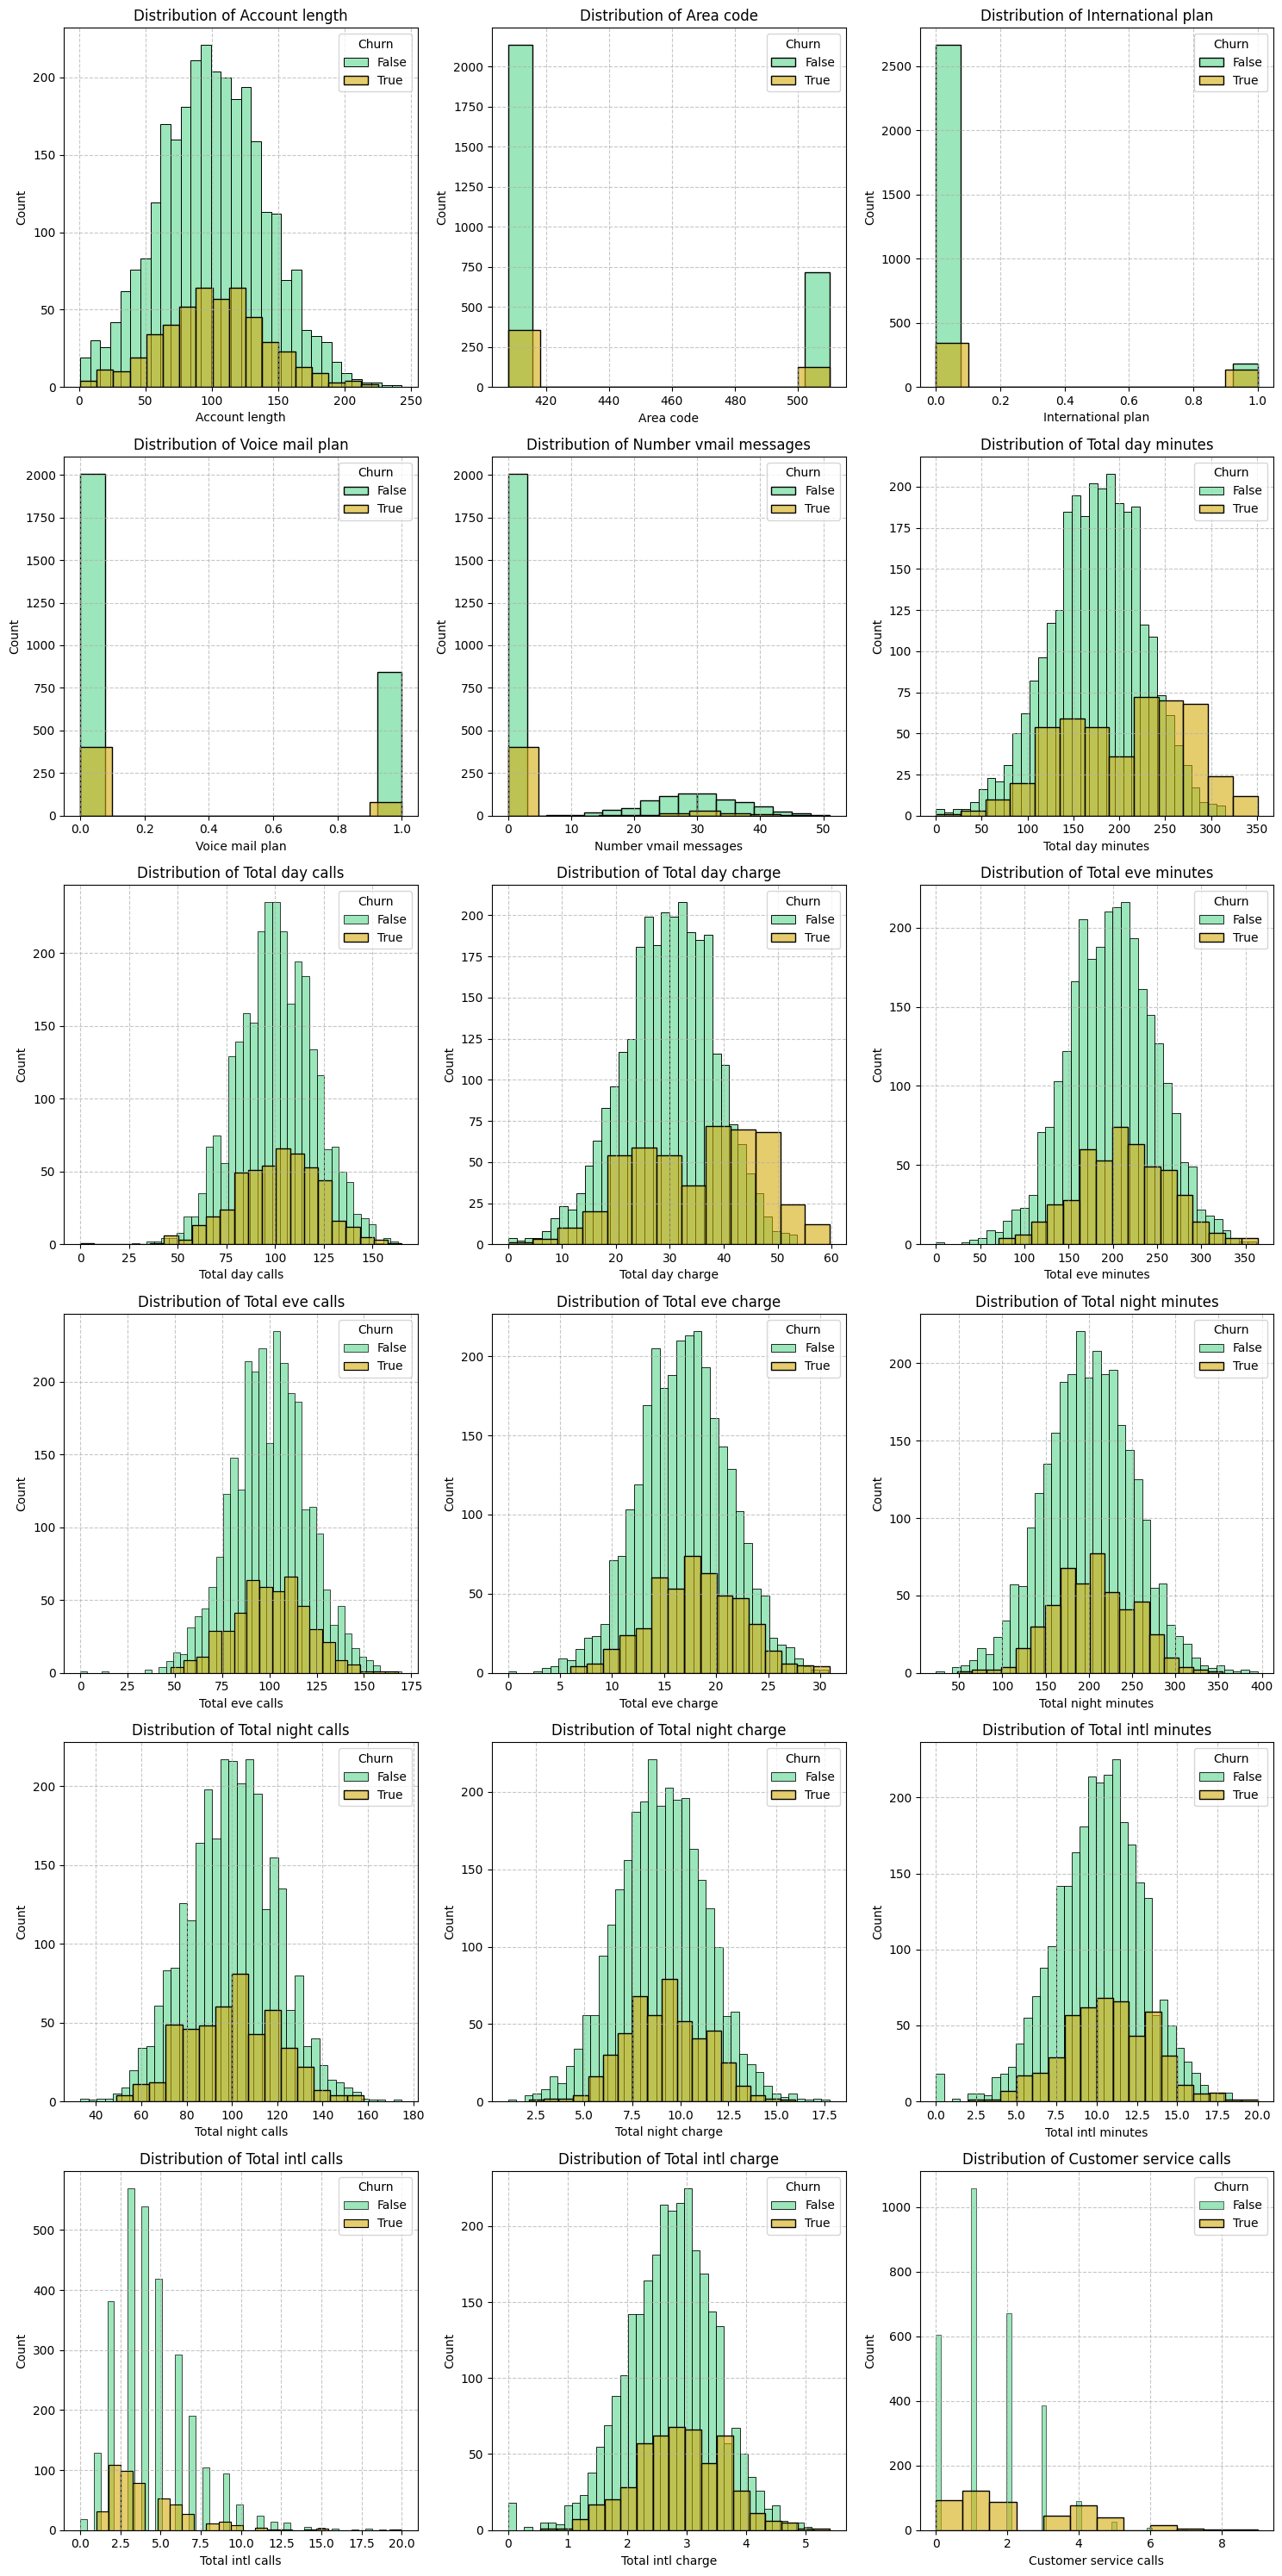

In [12]:
## create figure
n_cols = 3
n_rows = int(np.ceil(len(numerical_columns) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axes = axes.ravel()

# define colors for each class
colors = ['#58D68D', '#D4AC0D']

# create histograms for each numerical column
for idx, col in enumerate(numerical_columns):
    # Create histogram
    sns.histplot(data=churn_combined[churn_combined['Churn'] == 0], x=col,
                label='False', color=colors[0],
                stat='count', alpha=0.6,
                ax=axes[idx])

    sns.histplot(data=churn_combined[churn_combined['Churn'] == 1], x=col,
                label='True', color=colors[1],
                stat='count', alpha=0.6,
                ax=axes[idx] )

    axes[idx].set_title(f'Distribution of {col}')
    axes[idx].legend(title='Churn')
    axes[idx].grid(True, linestyle='--', alpha=0.7)


plt.tight_layout()
plt.show()

# Check for Class Imbalance

<ipython-input-13-76abadd528e5>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-13-76abadd528e5>:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(['Not Churned (0)', 'Churned (1)'])


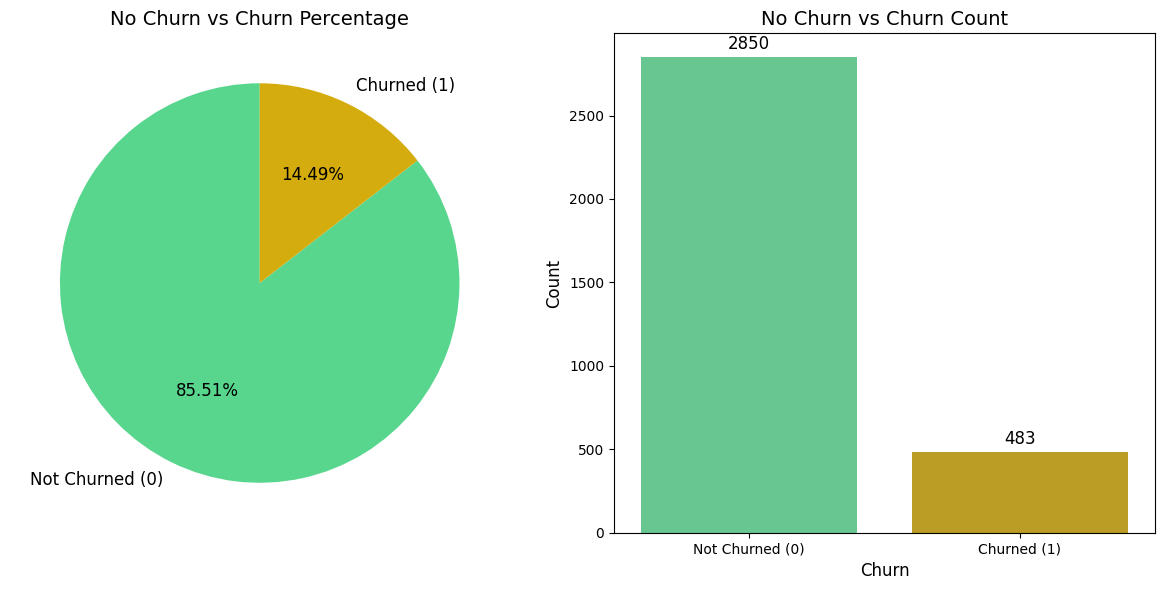

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count class distribution
churn_counts = churn_combined['Churn'].value_counts()
percentages = churn_counts / len(churn_combined) * 100  # Calculate percentages

# Create subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))


# Pie Chart: Churn percentage
axes[0].pie(
    percentages,
    labels=['Not Churned (0)', 'Churned (1)'],
    autopct='%1.2f%%',
    startangle=90,
    colors=['#58D68D', '#D4AC0D'],
    textprops={'fontsize': 12}
)
axes[0].set_title('No Churn vs Churn Percentage', fontsize=14)

# Bar Chart: Churn count
sns.barplot(
    x=churn_counts.index,
    y=churn_counts.values,
    ax=axes[1],
    palette=['#58D68D', '#D4AC0D']
)
for i, count in enumerate(churn_counts.values):
    axes[1].text(i, count + 50, f'{count}', ha='center', fontsize=12)

axes[1].set_title('No Churn vs Churn Count', fontsize=14)
axes[1].set_xlabel('Churn', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_xticklabels(['Not Churned (0)', 'Churned (1)'])

# Adjust layout
plt.tight_layout()
plt.show()


The dataset is highly imbalanced. There are 2850 Not Churned customers, and only 483 Churned customers. We need to use SMOTE for the imbalance ratio later.

# Check Correlation between features

<Axes: >

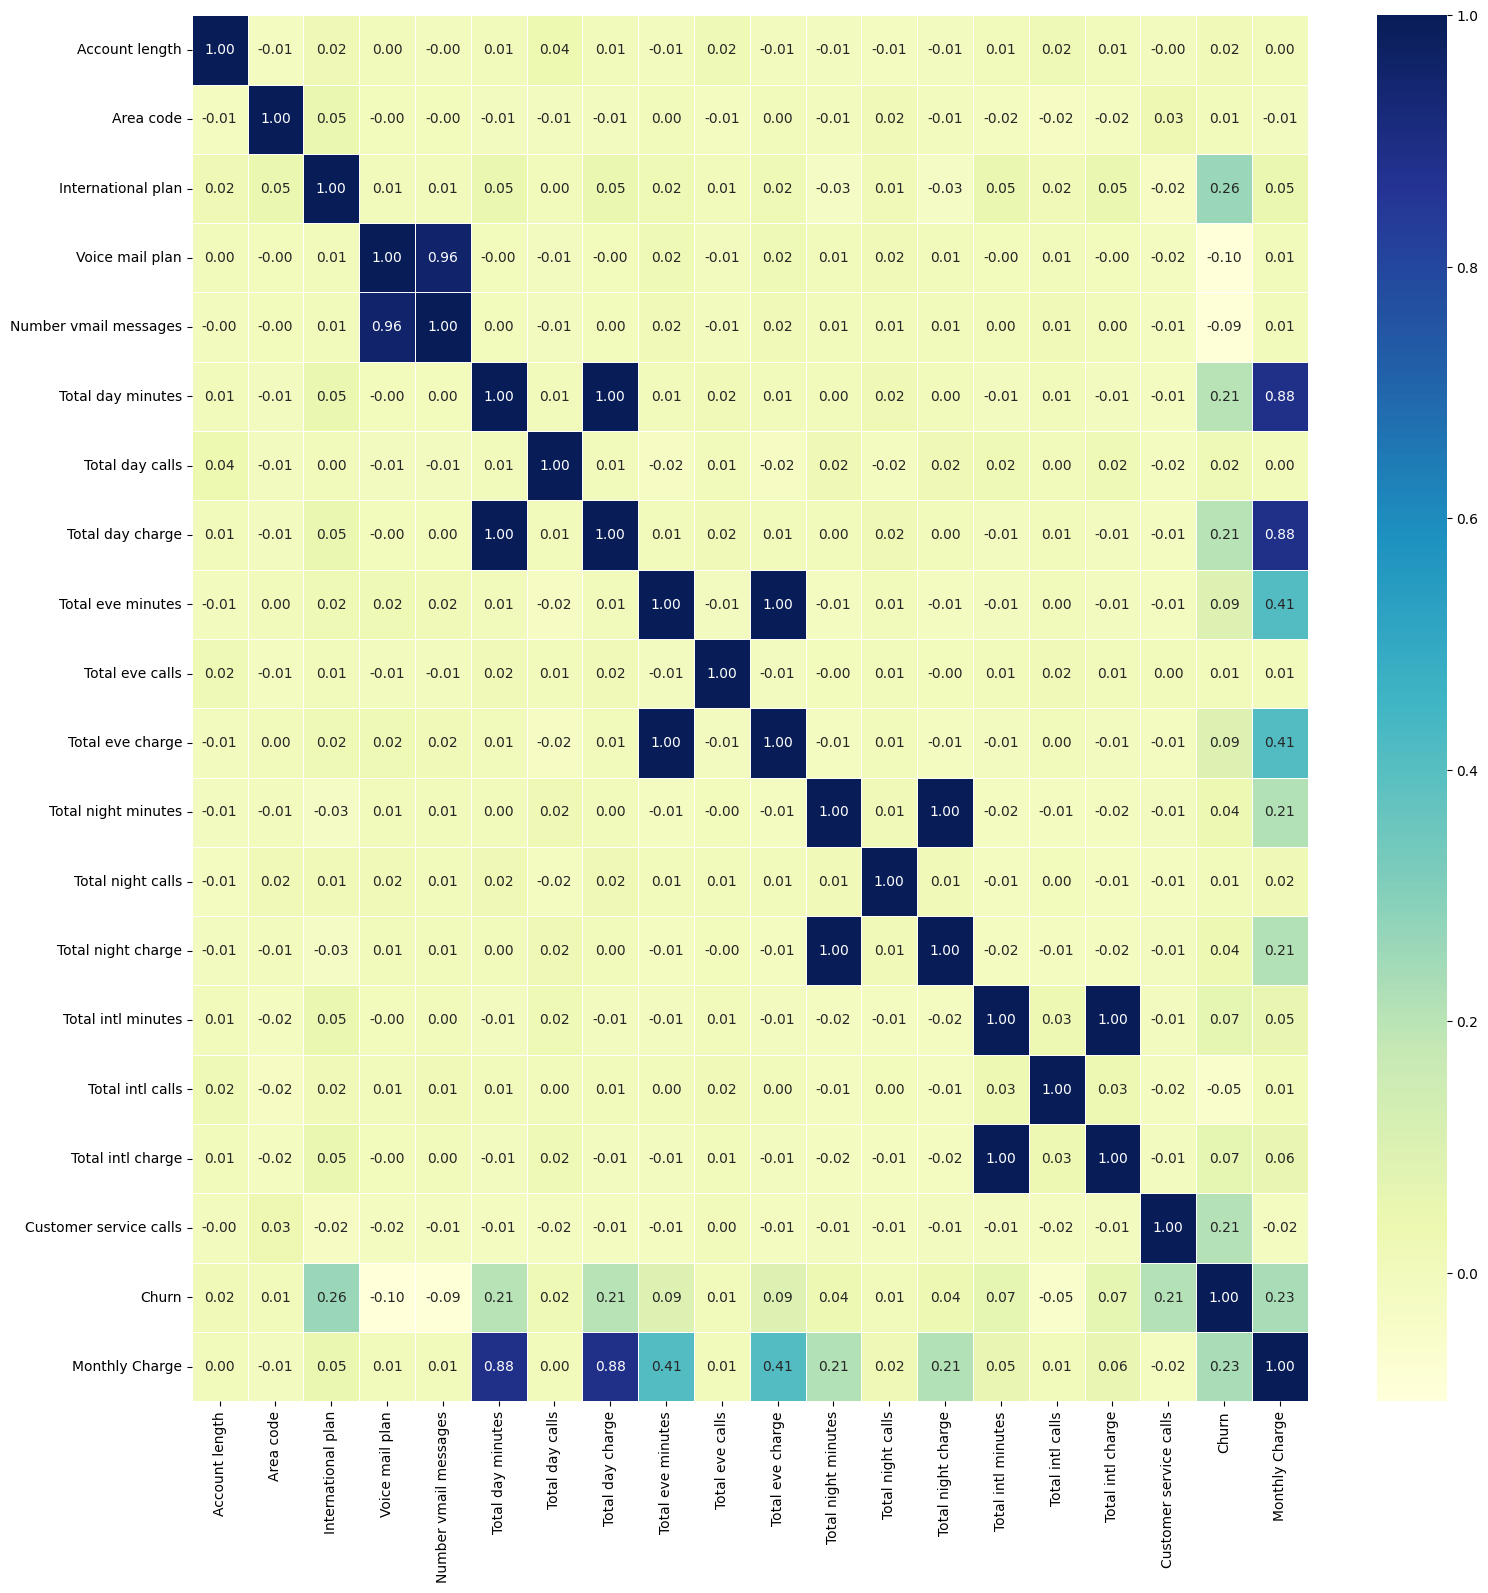

In [14]:
# plot correlations
plt.figure(figsize=(18,18))
sns.heatmap(churn_combined.corr(numeric_only=True),annot=True,cmap="YlGnBu",fmt=".2f",linewidths=0.5)

### Churn distribution of some important features

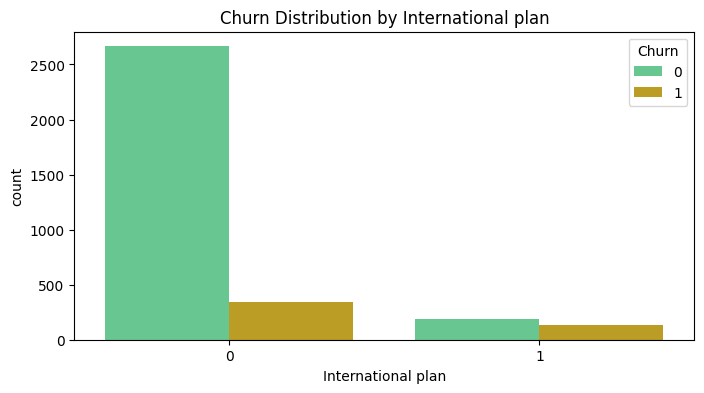

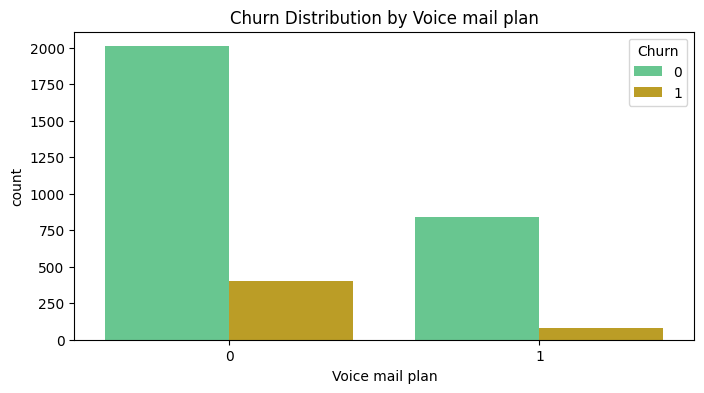

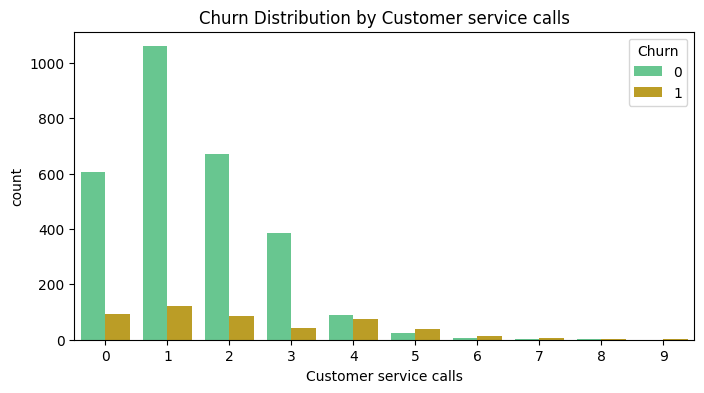

In [15]:
sns.set_palette(['#58D68D', '#D4AC0D'])

features = ['International plan', 'Voice mail plan','Customer service calls']

for feature in features:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=feature, hue='Churn', data=churn_combined)
    plt.title(f"Churn Distribution by {feature}")
    plt.show()

### Mean feature values by churn status: Comparing the mean values of features for churned and non-churned customers

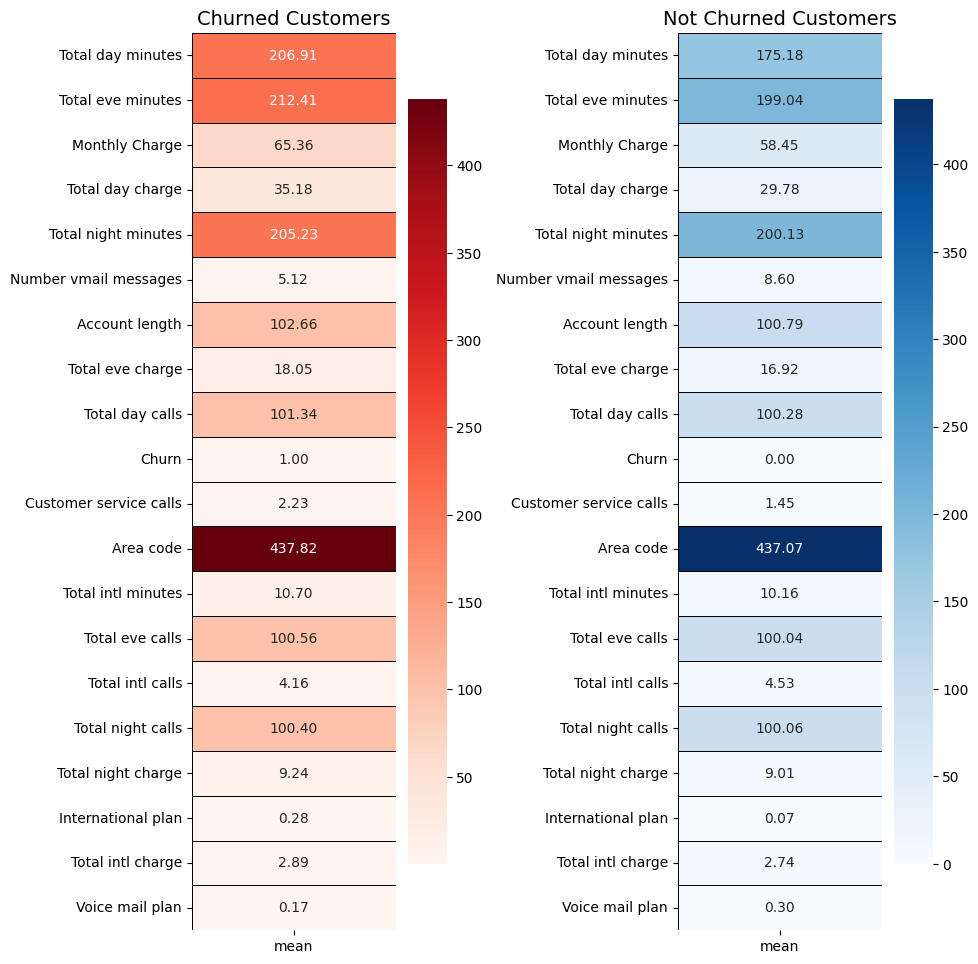

In [16]:

# Ensure numerical columns only
numerical_data = churn_combined.select_dtypes(include=['number'])

# Calculate mean values for churned and not churned customers
Churned = numerical_data[numerical_data['Churn'] == 1].describe().T
Not_Churned = numerical_data[numerical_data['Churn'] == 0].describe().T

# Calculate the absolute difference in means between the two groups
diff_means = abs(Churned['mean'] - Not_Churned['mean'])

# Sort based on the absolute difference
sorted_indices = diff_means.sort_values(ascending=False).index
Churned = Churned.loc[sorted_indices]
Not_Churned = Not_Churned.loc[sorted_indices]

# Heatmap Colors
colors_churned = 'Reds'
colors_not_churned = 'Blues'

# Create subplots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))

# Heatmap for Churned Customers
sns.heatmap(Churned[['mean']], annot=True, cmap=colors_churned, linewidths=0.4, linecolor='black', cbar=True, fmt='.2f', ax=ax[0])
ax[0].set_title('Churned Customers', fontsize=14)

# Heatmap for Not Churned Customers
sns.heatmap(Not_Churned[['mean']], annot=True, cmap=colors_not_churned, linewidths=0.4, linecolor='black', cbar=True, fmt='.2f', ax=ax[1])
ax[1].set_title('Not Churned Customers', fontsize=14)

# Adjust layout for better spacing
fig.tight_layout(pad=2)
plt.show()


## EDA conclusions:  
* Dataset has no missing values or duplicate values.  
* The dataset shows approximately normal distribution in most variables.  
* Class distribution shows imbalance.  
* There is multicollinearity between features (minutes and charges)


# Data Preprocessing

### Handling mulicollinearity

In [17]:
# Drop multicollinear features
columns = ['Total intl minutes', 'Total day minutes', 'Total night minutes', 'Total eve minutes']
churn_combined.drop(columns, axis = 1, inplace = True)

<Axes: >

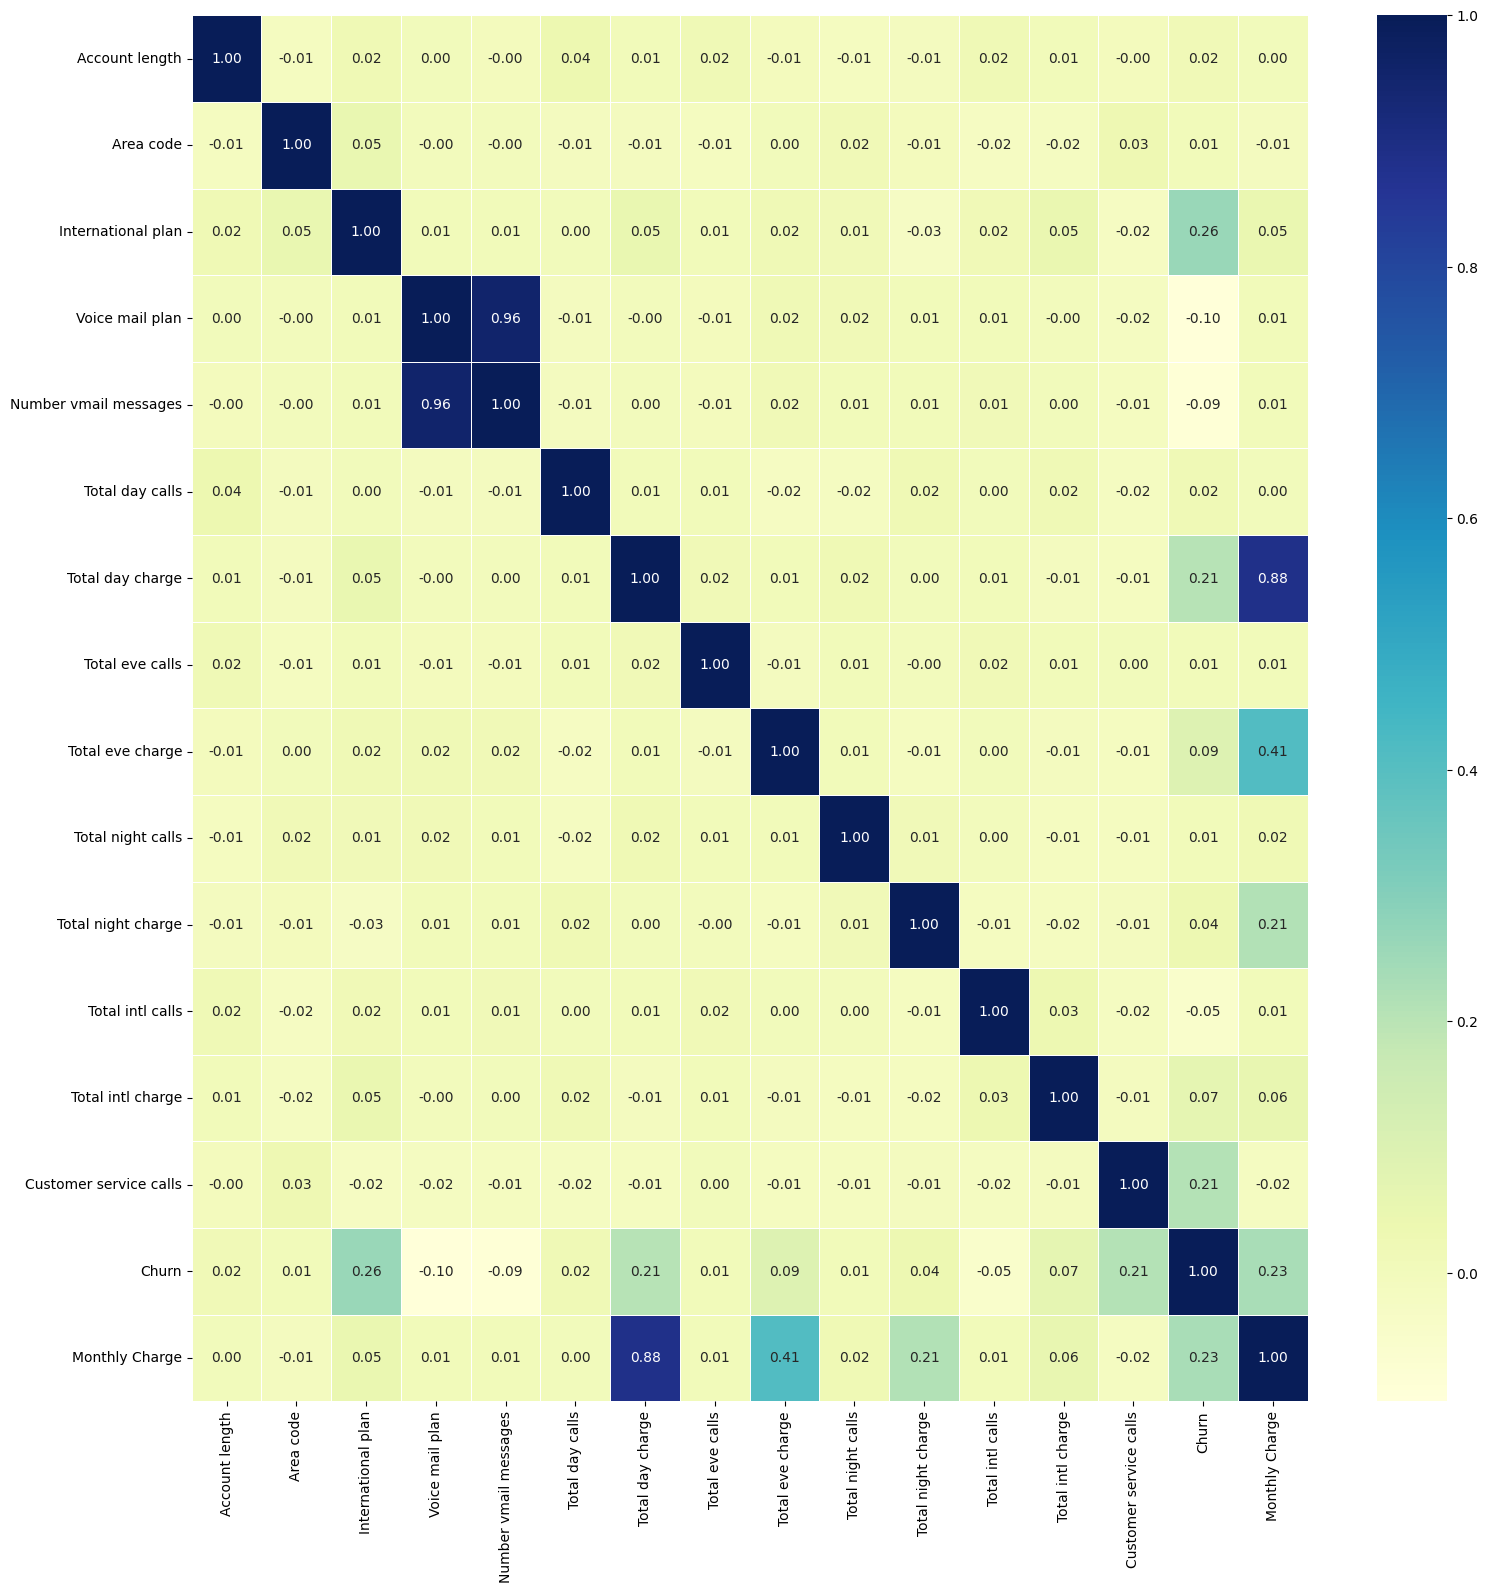

In [18]:
# Plot correlations
plt.figure(figsize=(18,18))
sns.heatmap(churn_combined.corr(numeric_only=True),annot=True,cmap="YlGnBu",fmt=".2f",linewidths=0.5)


### One Hot encode for Area code column

The Area code column is transformed using one-hot encoding. This creates new binary columns (one for each area code).

In [19]:
churn_combined= pd.get_dummies(churn_combined, columns=['Area code'], prefix = ['Area_code'])

### Split Data

In [20]:
X= churn_combined.drop('Churn', axis =1)
y= churn_combined['Churn']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

### Target encode for State column

In [21]:
state_mean_churn = X_train.join(y_train).groupby('State')['Churn'].mean()

# apply encoding to training data
X_train['state_encoded'] = X_train['State'].map(state_mean_churn)

# apply encoding to test data
X_test['state_encoded'] = X_test['State'].map(state_mean_churn)

# drop original `State` column
X_train.drop('State', axis=1, inplace=True)
X_test.drop('State', axis=1, inplace=True)

### SMOTE for Class Imbalance

In [22]:
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

Class Distribution Before SMOTE:
 Churn
0    2280
1     386
Name: count, dtype: int64

Class Distribution After SMOTE:
 Churn
0    2280
1    2280
Name: count, dtype: int64


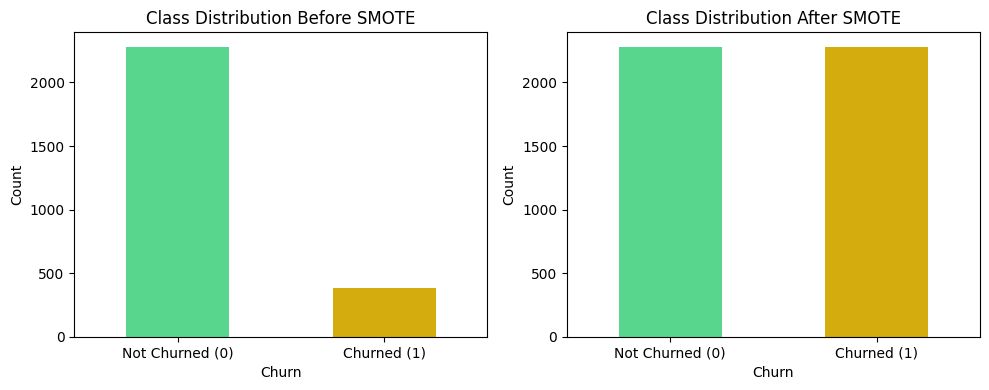

In [23]:
# Before SMOTE
churn_counts_before = y_train.value_counts()
print("Class Distribution Before SMOTE:\n", churn_counts_before)


# Check the class distribution after SMOTE
churn_counts_after = y_train_balanced.value_counts()
print("\nClass Distribution After SMOTE:\n", churn_counts_after)

# Plot the distributions side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plot BEFORE SMOTE
churn_counts_before.plot(kind='bar', ax=axes[0], color=['#58D68D', '#D4AC0D'])
axes[0].set_title('Class Distribution Before SMOTE')
axes[0].set_xlabel('Churn')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['Not Churned (0)', 'Churned (1)'], rotation=0)

# Plot AFTER SMOTE
churn_counts_after.plot(kind='bar', ax=axes[1], color=['#58D68D', '#D4AC0D'])
axes[1].set_title('Class Distribution After SMOTE')
axes[1].set_xlabel('Churn')
axes[1].set_ylabel('Count')
axes[1].set_xticklabels(['Not Churned (0)', 'Churned (1)'], rotation=0)

plt.tight_layout()
plt.show()


### Feature Scaling

In [24]:
# Scale balanced data
scaler = StandardScaler()
X_train_balanced = scaler.fit_transform(X_train_balanced)
X_test_balanced = scaler.transform(X_test)

In [25]:
X_train_balanced = pd.DataFrame(X_train_balanced, columns=X_train.columns)
X_test_balanced = pd.DataFrame(X_test_balanced, columns=X_test.columns)


In [26]:
# Scale unbalanced data
x_train= scaler.fit_transform(X_train)
x_test= scaler.transform(X_test)

x_train = pd.DataFrame(x_train, columns=X_train.columns)
x_test = pd.DataFrame(x_test, columns=X_test.columns)

x_train.head()

,Account length,International plan,Voice mail plan,Number vmail messages,Total day calls,Total day charge,Total eve calls,Total eve charge,Total night calls,Total night charge,Total intl calls,Total intl charge,Customer service calls,Monthly Charge,Area_code_408,Area_code_415,Area_code_510,state_encoded
0,-1.864555,-0.327327,-0.616954,-0.591217,-1.676747,0.873117,0.743245,0.918338,0.443262,-2.757121,0.628584,-0.878605,-0.426912,0.481704,-0.583414,1.001502,-0.572441,-0.539267
1,-1.637832,3.055050,1.620867,2.476994,-0.571218,0.309758,1.097219,1.055589,1.310946,-1.234625,0.628584,3.474391,-1.200637,0.684748,-0.583414,-0.998501,1.746903,0.749560
2,1.838589,-0.327327,1.620867,0.504573,2.142354,0.770195,0.743245,0.178577,0.443262,0.419880,1.859586,0.762038,-0.426912,0.892535,-0.583414,1.001502,-0.572441,0.541073
3,-0.907280,-0.327327,1.620867,1.088994,0.283055,0.813531,-0.015269,-0.235504,-1.292108,0.441881,-0.192084,-0.164132,-1.200637,0.699929,-0.583414,1.001502,-0.572441,0.541073
4,1.359951,-0.327327,-0.616954,-0.591217,-0.370212,-0.313187,0.085866,0.045978,0.443262,-0.825399,-0.192084,1.727900,0.346812,-0.309596,1.714048,-0.998501,-0.572441,0.797548


# Model Building

We build a function that accepts several parameters:  
- X_train, y_train: Training features and labels.
- X_test, y_test: Test features and labels.
- models: A dictionary of machine learning models to be tuned.
- param_grids: A dictionary where each key matches a model name and maps to a grid of hyperparameters for that model.
- cv: The cross-validation strategy to use.
- dataset_name: A string used to identify the dataset (e.g., "Unbalanced" or "Balanced")

We will measure the following metrics for models:  
- Accuracy: Proportion of correctly predicted instances.
- Precision: The ratio of true positive predictions to the total predicted positives.
- Recall: The ratio of true positive predictions to the actual positives.
- F1 Score: The harmonic mean of precision and recall.
- ROC AUC: The area under the receiver operating characterstic curve, used for evaluating binary classifiers

In [27]:
def tune_and_evaluate_models(X_train, y_train, X_test, y_test, models, param_grids, cv, dataset_name):

    # Dictionary to store results
    results = {}

    # Metrics to calculate
    metrics = {
        'Accuracy': accuracy_score,
        'Precision': precision_score,
        'Recall': recall_score,
        'F1 Score': f1_score,
        'ROC AUC': roc_auc_score
    }

    # Tune and evaluate each model
    for name, model in models.items():
        print(f"\n--- Tuning {name} on {dataset_name} Dataset ---")


        # Perform Grid Search
        grid = GridSearchCV(
            model, # The current model to tune
            param_grids[name], # The hyperparameter grid corresponding to this model
            cv=cv, # Specifies the cross-validation strategy
            scoring='roc_auc', # Use the ROC AUC metric to evaluate each hyperparameter combination
            n_jobs=-1, # Runs the grid search in parallel on all available CPU cores
            verbose=1 # Provides detailed output
        )
        grid.fit(X_train, y_train)

        # Best Model

        # Retrieve the best estimator
        best_model = grid.best_estimator_

        # Retrieve the best set of hyperparameters
        best_params = grid.best_params_

        # Predictions
        y_pred = best_model.predict(X_test)
        y_pred_proba = best_model.predict_proba(X_test)[:, 1]

        # Metrics Calculation
        model_metrics = {}
        for metric_name, metric_func in metrics.items():
            if metric_name in ['Precision', 'Recall', 'F1 Score']:
                model_metrics[metric_name] = metric_func(y_test, y_pred, average='weighted')
            elif metric_name == 'ROC AUC':
                try:
                    model_metrics[metric_name] = metric_func(y_test, y_pred_proba)
                except ValueError:
                    model_metrics[metric_name] = "Not applicable"
            else:
                model_metrics[metric_name] = metric_func(y_test, y_pred)

        # Results
        results[name] = {
            'Best Model': best_model,
            'Best Params': best_params,
            'Metrics': model_metrics,
            'Confusion Matrix': confusion_matrix(y_test, y_pred),
            'Classification Report': classification_report(y_test, y_pred),
            'y_pred_proba': y_pred_proba
        }

    return results

### Model Selection
The models we use are **Logistic Regression, Decision Tree, Random Forest and XGBoost.**
  
We first set up a cross-validation strategy that preserves the percentage of samples for each class in each fold

In [28]:
# Cross-Validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Parameter grids
param_grids = {
    'LogisticRegression': {
        'C': [0.01, 0.1, 1, 10, 100], # Inverse regularization strength
        'solver': ['liblinear', 'lbfgs'], # Algorithms for optimization
        'penalty': ['l2'], # Regularization method
    },
    'DecisionTree': {
        'max_depth': [5, 10, 20, None], # Maximum depth of the tree
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 5],
    },
    'RandomForest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
    },
    'XGBoost': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.3],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0],
    },
}


# models to evaluate
models = {
    'LogisticRegression': LogisticRegression(random_state=42),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(
        random_state=42,
        eval_metric='logloss',
        n_jobs=-1
    )

}

In [29]:
# Compute a weight ratio for the majority and minority classes
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

# Models for class imbalance
models_weighted_loss = {
    'LogisticRegression': LogisticRegression(random_state=42, class_weight='balanced'),
    'DecisionTree': DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    'RandomForest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'XGBoost': xgb.XGBClassifier(
        random_state=42,
        eval_metric='logloss',
        n_jobs=-1,
        scale_pos_weight=scale_pos_weight
    )
}

# Model Evaluation
- Unbalanced Dataset: Models are evaluated using the original, unbalanced data.
- Balanced SMOTE Dataset: Models are evaluated on the dataset after SMOTE balancing.
- Unbalanced (Class-Weighted Models): The class-weighted versions of the models

In [30]:
# Evaluate models on the unbalanced dataset
unbalanced_results = tune_and_evaluate_models(
    x_train, y_train, x_test, y_test,
    models, param_grids, cv,
    dataset_name='Unbalanced'
)

# Evaluate models on the balanced dataset (SMOTE)
balanced_results_smote = tune_and_evaluate_models(
    X_train_balanced, y_train_balanced,
    X_test_balanced, y_test,
    models, param_grids, cv,
    dataset_name='Balanced SMOTE'
)

# Evaluate models on the unbalanced dataset (Weighted Loss)
balanced_results_weighted_loss = tune_and_evaluate_models(
    x_train, y_train, x_test, y_test,
    models_weighted_loss, param_grids, cv,
    dataset_name='Unbalanced (Class-Weighted Models)'
)


--- Tuning LogisticRegression on Unbalanced Dataset ---
Fitting 5 folds for each of 10 candidates, totalling 50 fits

--- Tuning DecisionTree on Unbalanced Dataset ---
Fitting 5 folds for each of 36 candidates, totalling 180 fits

--- Tuning RandomForest on Unbalanced Dataset ---
Fitting 5 folds for each of 81 candidates, totalling 405 fits

--- Tuning XGBoost on Unbalanced Dataset ---
Fitting 5 folds for each of 54 candidates, totalling 270 fits

--- Tuning LogisticRegression on Balanced SMOTE Dataset ---
Fitting 5 folds for each of 10 candidates, totalling 50 fits

--- Tuning DecisionTree on Balanced SMOTE Dataset ---
Fitting 5 folds for each of 36 candidates, totalling 180 fits

--- Tuning RandomForest on Balanced SMOTE Dataset ---
Fitting 5 folds for each of 81 candidates, totalling 405 fits

--- Tuning XGBoost on Balanced SMOTE Dataset ---
Fitting 5 folds for each of 54 candidates, totalling 270 fits

--- Tuning LogisticRegression on Unbalanced (Class-Weighted Models) Dataset ---

In [32]:
# Printing results
def print_results(results):
    for model_name, model_results in results.items():
        print(f"\n{model_name} Results:")
        print("Best Parameters:", model_results['Best Params'])
        print("\nMetrics:")
        for metric, value in model_results['Metrics'].items():
            print(f"{metric}: {value}")
        print("\nClassification Report:")
        print(model_results['Classification Report'])

print("\n--- Unbalanced Dataset Results ---")
print_results(unbalanced_results)

print("\n--- Balanced Dataset (SMOTE) Results ---")
print_results(balanced_results_smote)

print("\n--- Unbalanced Dataset (Class-Weighted Models) Results ---")
print_results(balanced_results_weighted_loss)



--- Unbalanced Dataset Results ---

LogisticRegression Results:
Best Parameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}

Metrics:
Accuracy: 0.8665667166416792
Precision: 0.8420565259166082
Recall: 0.8665667166416792
F1 Score: 0.8406920439326255
ROC AUC: 0.8204376921685658

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.97      0.93       570
           1       0.61      0.24      0.34        97

    accuracy                           0.87       667
   macro avg       0.74      0.61      0.63       667
weighted avg       0.84      0.87      0.84       667


DecisionTree Results:
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10}

Metrics:
Accuracy: 0.9820089955022488
Precision: 0.9821210084612867
Recall: 0.9820089955022488
F1 Score: 0.981598331269148
ROC AUC: 0.9558419243986254

Classification Report:
              precision    recall  f1-score   support

           0       0.98  

In [33]:
def create_results_dataframe(results):

    data = []
    for model, result in results.items():
        metrics = result['Metrics']
        data.append([
            model,
            metrics['Accuracy'],
            metrics['Precision'],
            metrics['Recall'],
            metrics['F1 Score'],
            metrics['ROC AUC']
        ])

    df = pd.DataFrame(data, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC'])
    return df

# Create DataFrames
unbalanced_df = create_results_dataframe(unbalanced_results)
balanced_smote_df = create_results_dataframe(balanced_results_smote)
balanced_weighted_loss_df = create_results_dataframe(balanced_results_weighted_loss)

# Sort DataFrames by F1 Score
unbalanced_df = unbalanced_df.sort_values(by='F1 Score', ascending=False)
balanced_smote_df = balanced_smote_df.sort_values(by='F1 Score', ascending=False)
balanced_weighted_loss_df = balanced_weighted_loss_df.sort_values(by='F1 Score', ascending=False)

# Display
print("Unbalanced Dataset Results:")
display(unbalanced_df)
print('-------------------------------------------------')
print("Unbalanced Dataset (Class-Weighted Models) Results:")
display(balanced_weighted_loss_df)
print('-------------------------------------------------')
print("Balanced Dataset (SMOTE) Results:")
display(balanced_smote_df)


Unbalanced Dataset Results:


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
1,DecisionTree,0.982009,0.982121,0.982009,0.981598,0.955842
2,RandomForest,0.973013,0.973840,0.973013,0.971843,0.943688
3,XGBoost,0.958021,0.959987,0.958021,0.954984,0.950814
0,LogisticRegression,0.866567,0.842057,0.866567,0.840692,0.820438


-------------------------------------------------
Unbalanced Dataset (Class-Weighted Models) Results:


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
3,XGBoost,0.982009,0.982121,0.982009,0.981598,0.948436
2,RandomForest,0.970015,0.971031,0.970015,0.968550,0.942286
1,DecisionTree,0.922039,0.939086,0.922039,0.926869,0.953608
0,LogisticRegression,0.785607,0.866687,0.785607,0.811100,0.831850


-------------------------------------------------
Balanced Dataset (SMOTE) Results:


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
2,RandomForest,0.967016,0.966652,0.967016,0.965934,0.961711
3,XGBoost,0.965517,0.964966,0.965517,0.965136,0.964750
1,DecisionTree,0.949025,0.952467,0.949025,0.950239,0.941771
0,LogisticRegression,0.817091,0.834038,0.817091,0.824607,0.806475


### Visualizations for Class-Weighted Models

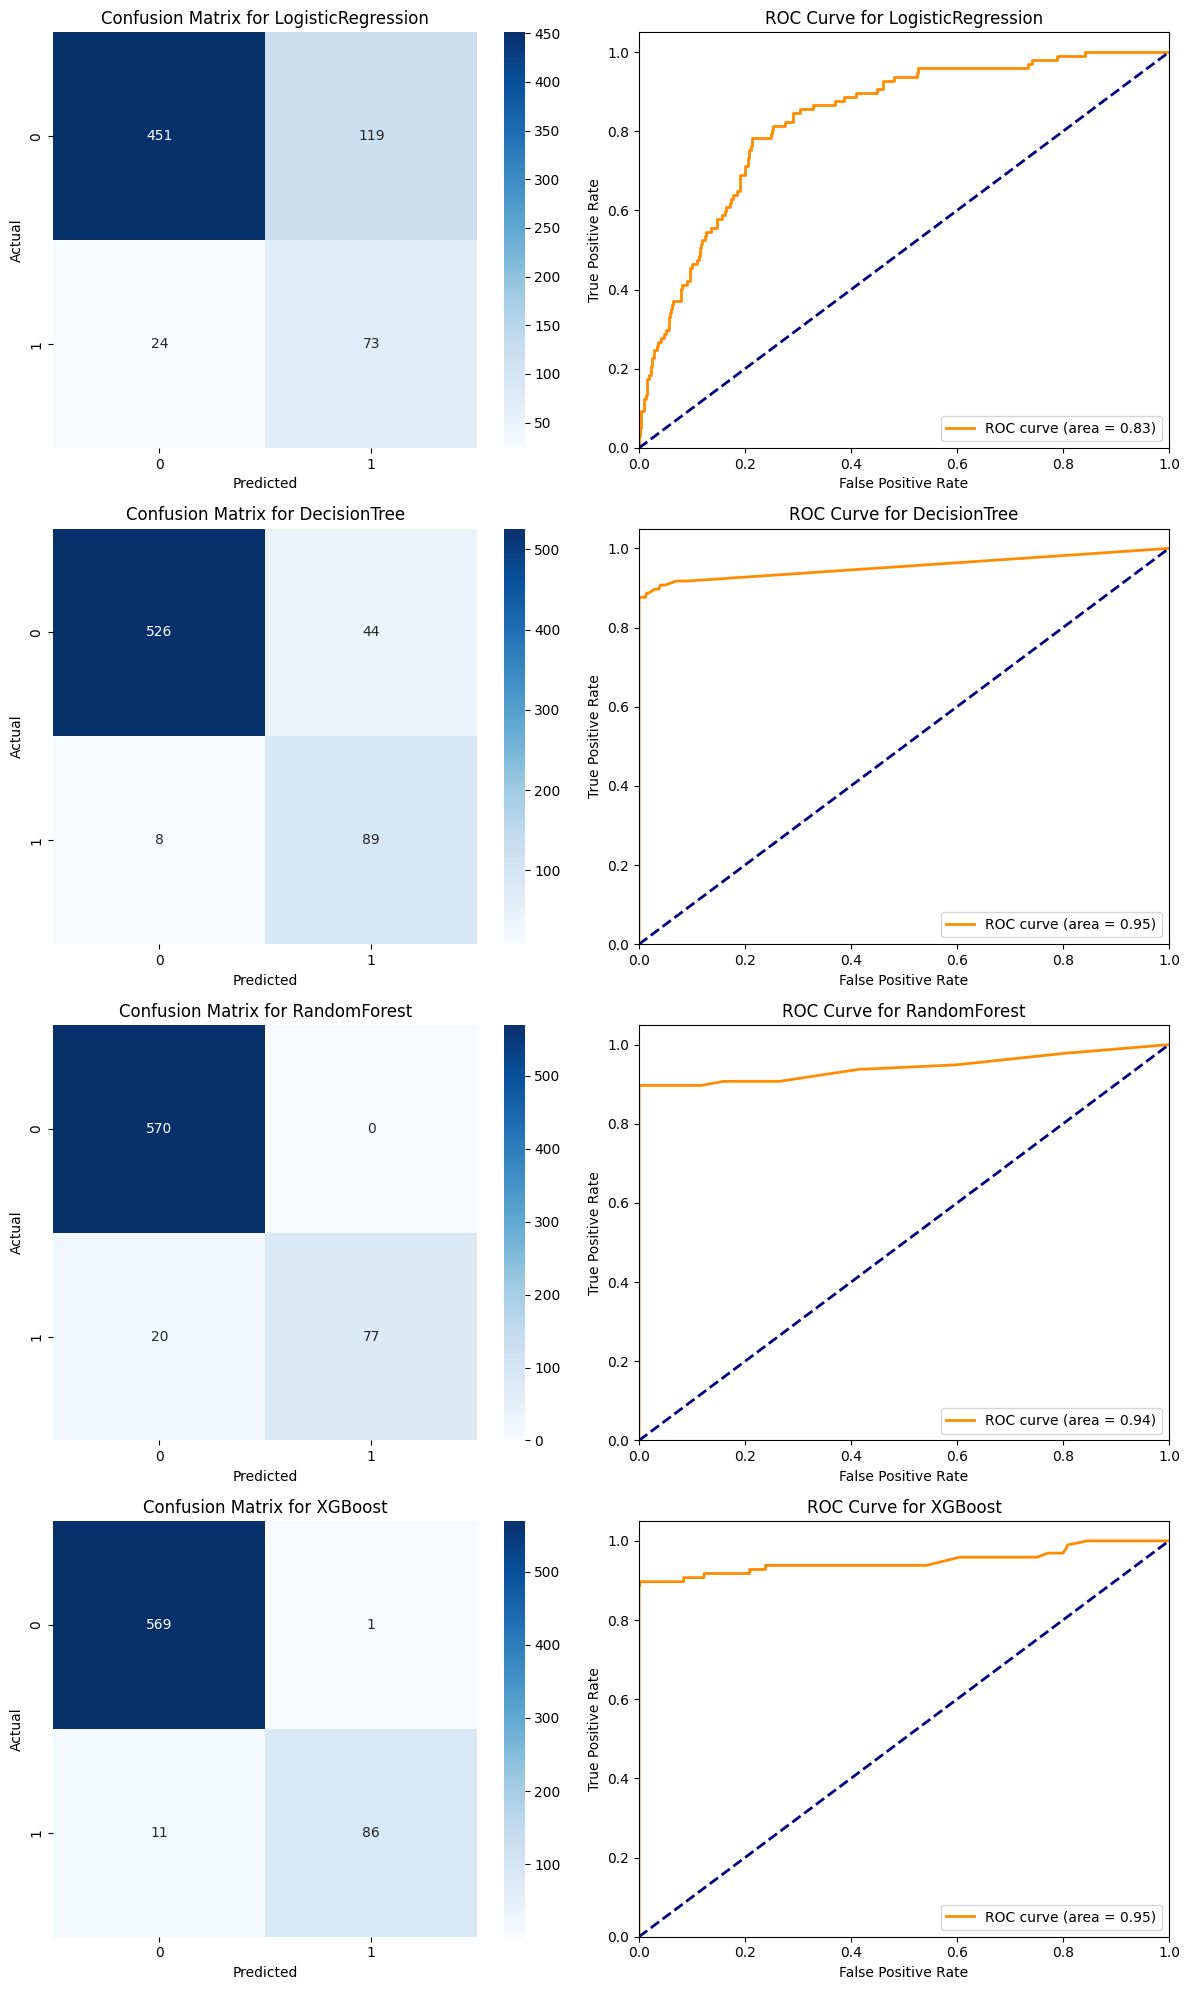

In [34]:
def plot_confusion_matrix(ax, cm, model_name):
    """
    Plot confusion matrix for a given model.
    """
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'Confusion Matrix for {model_name}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

def plot_roc_curve(ax, y_test, y_pred_proba, model_name):
    """
    Plot ROC curve for a given model.
    """
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve for {model_name}')
    ax.legend(loc='lower right')

# Number of models
num_models = len(balanced_results_weighted_loss)

# Create subplots
fig, axes = plt.subplots(num_models, 2, figsize=(12, 5 * num_models))

# Plot confusion matrices and ROC curves for the models
for i, (model_name, result) in enumerate(balanced_results_weighted_loss.items()):
    cm = result['Confusion Matrix']
    y_pred_proba = result['y_pred_proba']

    # Plot confusion matrix
    plot_confusion_matrix(axes[i, 0], cm, model_name)

    # Plot ROC curve
    plot_roc_curve(axes[i, 1], y_test, y_pred_proba, model_name)

# Adjust layout
plt.tight_layout()
plt.show()

# Conclusions
- XGBoost outperformed Logistic Regression, Decision Trees, and Random Forest in terms of both discrimination (as measured by ROC AUC) and overall predictive metrics.  
- XGBoost’s gradient boosting framework allows it to capture complex non-linear relationships and interactions between features better than simpler models like logistic regression or single decision trees. This ability is crucial in churn prediction, where customer behavior often depends on subtle, combined effects of multiple factors.  
- With class imbalance being a significant challenge in churn datasets, XGBoost—when tuned with appropriate hyperparameters—demonstrated a superior ability to distinguish between churned and non-churned customers. The model achieved the highest ROC AUC, which indicates its effectiveness at ranking customers by their likelihood of churning.  
- While Random Forest also performed well as an ensemble method, XGBoost provided slightly better generalization on the test set. Its regularization features and boosting strategy contributed to a more robust model that avoids overfitting.



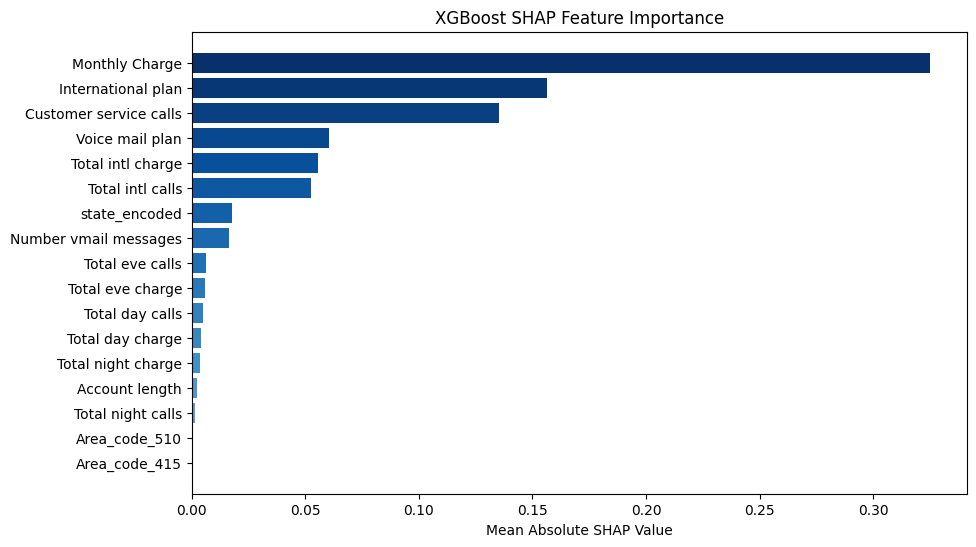

In [ ]:
import shap


def plot_shap_feature_importances(model, X, feature_names, model_name, top_n=17):
    # Create a SHAP explainer for the model
    explainer = shap.TreeExplainer(model)
    # Compute SHAP values for the provided dataset
    shap_values = explainer.shap_values(X)

    # Calculate the mean absolute SHAP value for each feature
    mean_abs_shap = np.mean(np.abs(shap_values), axis=0)

    # Get indices of the top n features based on mean absolute SHAP value
    indices = np.argsort(mean_abs_shap)[-top_n:]
    top_features = [feature_names[i] for i in indices]
    top_shap_values = mean_abs_shap[indices]

    # Create a colormap for the bars with shades of blue
    cmap = plt.cm.Blues
    colors = cmap(np.linspace(0.5, 1, top_n))

    plt.figure(figsize=(10, 6))
    plt.barh(range(top_n), top_shap_values, align='center', color=colors)
    plt.yticks(range(top_n), top_features)
    plt.xlabel("Mean Absolute SHAP Value")
    plt.title(f'{model_name} SHAP Feature Importance')
    plt.show()

    return explainer, shap_values


best_xgboost_model = balanced_results_weighted_loss['XGBoost']['Best Model']
feature_names = x_train.columns

# Plot SHAP-based feature importances for XGBoost and get the explainer and SHAP values
explainer, shap_values = plot_shap_feature_importances(best_xgboost_model, x_train, feature_names, 'XGBoost')




# Prediction
We will use the XGBoost Model for our prediction.

In [35]:
xgb_best = balanced_results_smote['XGBoost']['Best Model']

We define a predict_churn function using the following parameters:  
- new_customer_raw: raw customer data
- scaler: fitted Standardscaler as our previous training process.
- state_mean_churn: mapping from State to its target-encoded.
- xgb_best: The best model XGBoost

In [36]:
def predict_churn(new_customer_raw, scaler, state_mean_churn, xgb_best):

    # Convert categorical plan fields to numeric
    new_customer_raw['International plan'] = 1 if new_customer_raw['International plan'] == 'Yes' else 0
    new_customer_raw['Voice mail plan'] = 1 if new_customer_raw['Voice mail plan'] == 'Yes' else 0

    # One-hot encode the Area code.
    # Assuming thetraining data created dummy variables: 'Area_code_408', 'Area_code_415', 'Area_code_510'
    area_codes = {'Area_code_408': 0, 'Area_code_415': 0, 'Area_code_510': 0}
    if new_customer_raw['Area code'] == 408:
        area_codes['Area_code_408'] = 1
    elif new_customer_raw['Area code'] == 415:
        area_codes['Area_code_415'] = 1
    elif new_customer_raw['Area code'] == 510:
        area_codes['Area_code_510'] = 1

    # Target encode the State using your mapping from training.
    state_encoded = state_mean_churn.get(new_customer_raw['State'], 0)

    # Create a dictionary of features matching the ones used during training.
    features = {
        'Account length': new_customer_raw['Account length'],
        'International plan': new_customer_raw['International plan'],
        'Voice mail plan': new_customer_raw['Voice mail plan'],
        'Number vmail messages': new_customer_raw['Number vmail messages'],
        'Total day calls': new_customer_raw['Total day calls'],
        'Total day charge': new_customer_raw['Total day charge'],
        'Total eve calls': new_customer_raw['Total eve calls'],
        'Total eve charge': new_customer_raw['Total eve charge'],
        'Total night calls': new_customer_raw['Total night calls'],
        'Total night charge': new_customer_raw['Total night charge'],
        'Total intl calls': new_customer_raw['Total intl calls'],
        'Total intl charge': new_customer_raw['Total intl charge'],
        'Customer service calls': new_customer_raw['Customer service calls'],
        'state_encoded': state_encoded
    }
    # Incorporate the one-hot encoded Area code variables
    features.update(area_codes)

    # Convert to DataFrame
    new_customer_df = pd.DataFrame([features])

    new_customer_df = new_customer_df.reindex(columns=scaler.feature_names_in_, fill_value=0)

    # Scale the new customer data
    scaled_new_customer = scaler.transform(new_customer_df)

    # Use the best XGBoost model to predict churn probability
    churn_probability = xgb_best.predict_proba(scaled_new_customer)[:, 1]

    return churn_probability[0]

Test the prediction function with a sample new customer

In [37]:
sample_customer = {
    'Account length': 120,
    'State': 'OH',
    'Area code': 415,
    'International plan': 'No',
    'Voice mail plan': 'Yes',
    'Number vmail messages': 30,
    'Total day minutes': 250.0,
    'Total day calls': 105,
    'Total day charge': 38.0,
    'Total eve minutes': 160.0,
    'Total eve calls': 100,
    'Total eve charge': 22.0,
    'Total night minutes': 220.0,
    'Total night calls': 95,
    'Total night charge': 10.0,
    'Total intl minutes': 8.0,
    'Total intl calls': 2,
    'Total intl charge': 2.0,
    'Customer service calls': 1
}

In [ ]:
# Predict churn probability for the sample customer
predicted_prob = predict_churn(sample_customer, scaler, state_mean_churn, xgb_best)
print("Predicted churn probability for the sample customer: {:.2f}%".format(predicted_prob * 100))

Predicted churn probability for the sample customer: 7.98%


# Customer Segmentation

We will collect new customer information from user input, predict their churn probability with the trained XGBoost model, and categorizes them into risk segments based on that probability.

In [38]:
def get_new_customer_data():
    new_customer = {}
    new_customer['International plan'] = input("International plan (Yes/No): ").strip()
    new_customer['Voice mail plan'] = input("Voice mail plan (Yes/No): ").strip()
    new_customer['Area code'] = int(input("Area code (408/415/510): ").strip())
    new_customer['State'] = input("State: ").strip()
    new_customer['Account length'] = float(input("Account length (e.g., in months): ").strip())
    new_customer['Number vmail messages'] = int(input("Number vmail messages: ").strip())
    new_customer['Total day calls'] = int(input("Total day calls: ").strip())
    new_customer['Total day charge'] = float(input("Total day charge: ").strip())
    new_customer['Total eve calls'] = int(input("Total eve calls: ").strip())
    new_customer['Total eve charge'] = float(input("Total eve charge: ").strip())
    new_customer['Total night calls'] = int(input("Total night calls: ").strip())
    new_customer['Total night charge'] = float(input("Total night charge: ").strip())
    new_customer['Total intl calls'] = int(input("Total intl calls: ").strip())
    new_customer['Total intl charge'] = float(input("Total intl charge: ").strip())
    new_customer['Customer service calls'] = int(input("Customer service calls: ").strip())
    return new_customer

new_customer_raw = get_new_customer_data()

predicted_probability = predict_churn(new_customer_raw, scaler, state_mean_churn, xgb_best)

def segment_customer(churn_probability, low_threshold=0.3, high_threshold=0.7):
    if churn_probability < low_threshold:
        return 'Low Risk'
    elif churn_probability < high_threshold:
        return 'Medium Risk'
    else:
        return 'High Risk'

customer_segment = segment_customer(predicted_probability)

print(f"Predicted Churn Probability: {predicted_probability:.2f}")
print(f"Customer Segment: {customer_segment}")


International plan (Yes/No): Yes
Voice mail plan (Yes/No): Yes
Area code (408/415/510): 510
State: OH
Account length (e.g., in months): 120
Number vmail messages: 30
Total day calls: 105
Total day charge: 38
Total eve calls: 100
Total eve charge: 22
Total night calls: 95
Total night charge: 10
Total intl calls: 2
Total intl charge: 1
Customer service calls: 1
Predicted Churn Probability: 0.85
Customer Segment: High Risk
